In [2]:
import plotting_functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploratory Analysis of Real Commodities Data

## Currency Basket

We choose the returns of three currencies which are heavily linked to the performance of commodities markets in order to create a market benchmark against which to compare the performance of each commodity. To this end, we consider the average of the returns of the Canadian Dollar (CAD), Australian Dollar (AUD), and the Mexican Peso when paired with the US Dollar (USD). The resulting augmented "commodities currency basket" series is analysed in this section.

In [3]:
# Create list of currency names
currency_list = ['CME Australian Dollar AUD',
                 'CME Mexican Peso',
                 'CME Canadian Dollar CAD']

# Initialise empty dataframes with full indexing
currency_dict = {currency:  pd.DataFrame([], index = pd.bdate_range(start = '1/1/1980', end = '7/31/2020')) for currency in currency_list}

# Loop through each currency and load the data into the waiting dataframne
for currency in currency_list:
    
    current_df = pd.read_csv('Data/Continuous Futures Series/{}.csv'.format(currency), index_col = 0, skiprows = 0, skipfooter = 1, header = 1, engine = 'python')
    current_df.index = pd.to_datetime(current_df.index)
    
    currency_dict[currency] = currency_dict[currency].join(current_df)

In [4]:
from plotting_functions import series_plot

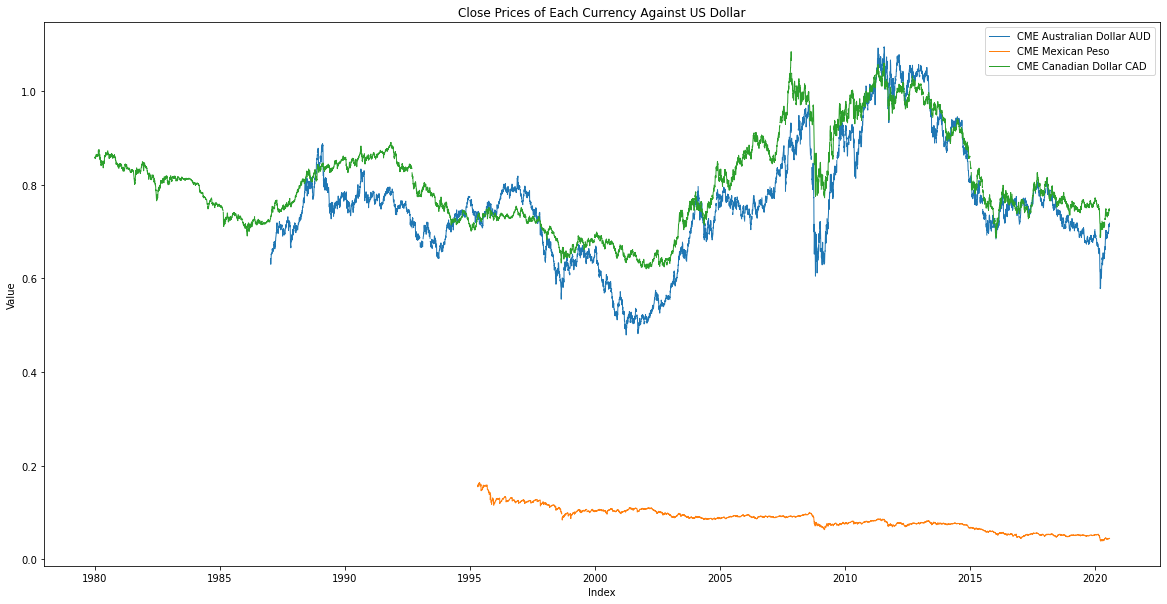

In [5]:
# Create empty dataframe of currency close prices to be filled in
currency_close_df = pd.DataFrame([], index = currency_dict['CME Canadian Dollar CAD'].index)

# Loop through each currency dataframe and pull its close price data
for currency in currency_list:
    
    currency_close_df[currency] = currency_dict[currency]['Close']
    
series_plot(currency_close_df,'Close Prices of Each Currency Against US Dollar',legend=True)

While the CAD and AUD have data available back to 1980, the Peso as it is currently traded ws introduced in January 1996. As such, its series only has data available beginning near to this date. This will not be an issue, as 24 years of available daily data will be more than suitable for our purposes and we will see that our useable data range will be limited further still by similar constraints on the commodities returns data.

### Simple Average of Currencies

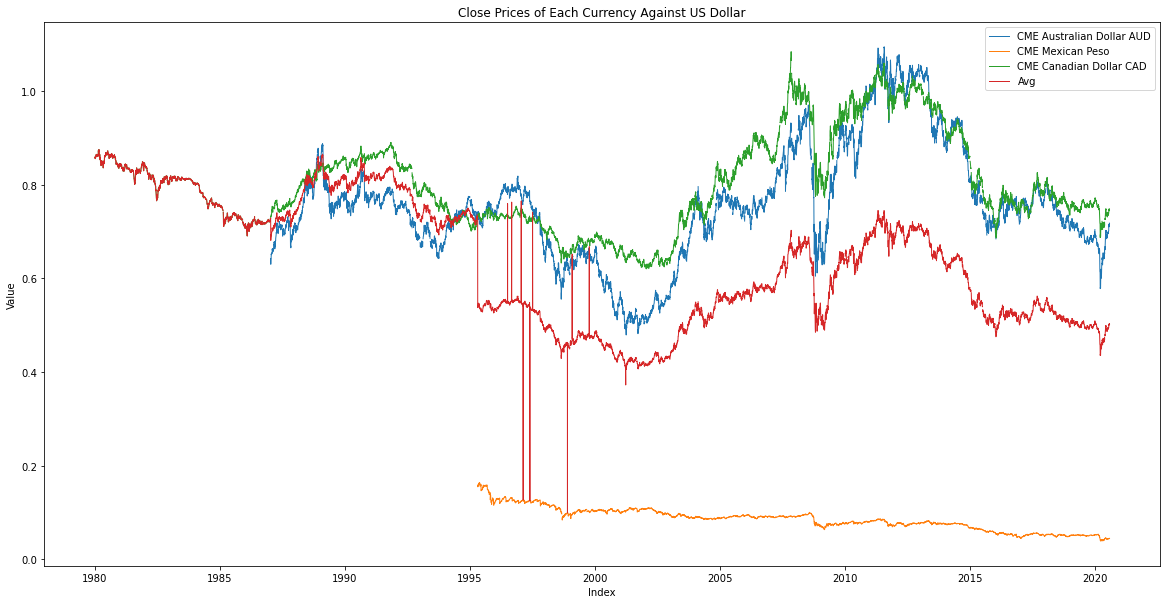

In [6]:
currency_close_df_copy = currency_close_df.copy()
currency_close_df_copy['Avg'] = currency_close_df.copy().mean(axis=1)

series_plot(currency_close_df_copy,'Close Prices of Each Currency Against US Dollar',legend=True)

The sharp spikes in the plotted data are a result of gaps in either the North American or Australian currencies. A sharp spike up is a result of missing data in the AUD, while a sharp spike down is caused by missing data in CAD and the Peso series. This is confirmed by the following plot, which is the same as the plot above but with missing data filled forwards.

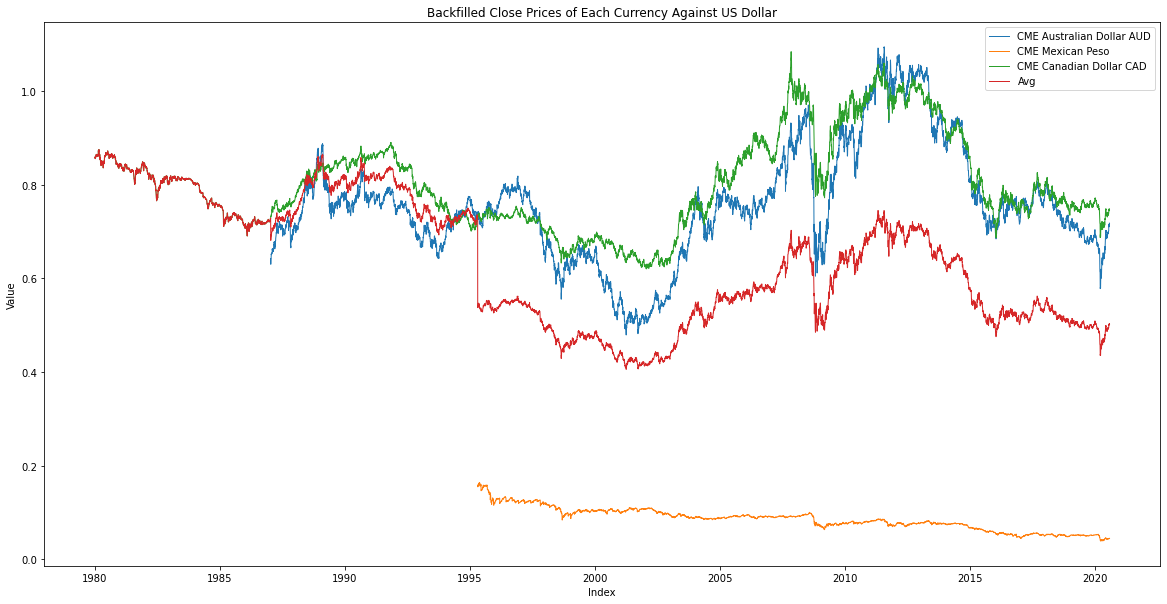

In [7]:
currency_close_df = currency_close_df.fillna(method='ffill')
currency_close_df['Avg'] = currency_close_df.mean(axis=1)

series_plot(currency_close_df,'Backfilled Close Prices of Each Currency Against US Dollar', legend=True)

We will choose not to backfill any missing dates, as this will be equivalent to having information about price data ahead of time. Instead we will fill empty data with the last known price point. As this is not possible for series that haven't yet registered any data, we truncate all currency data to the beginning date of the AUD.

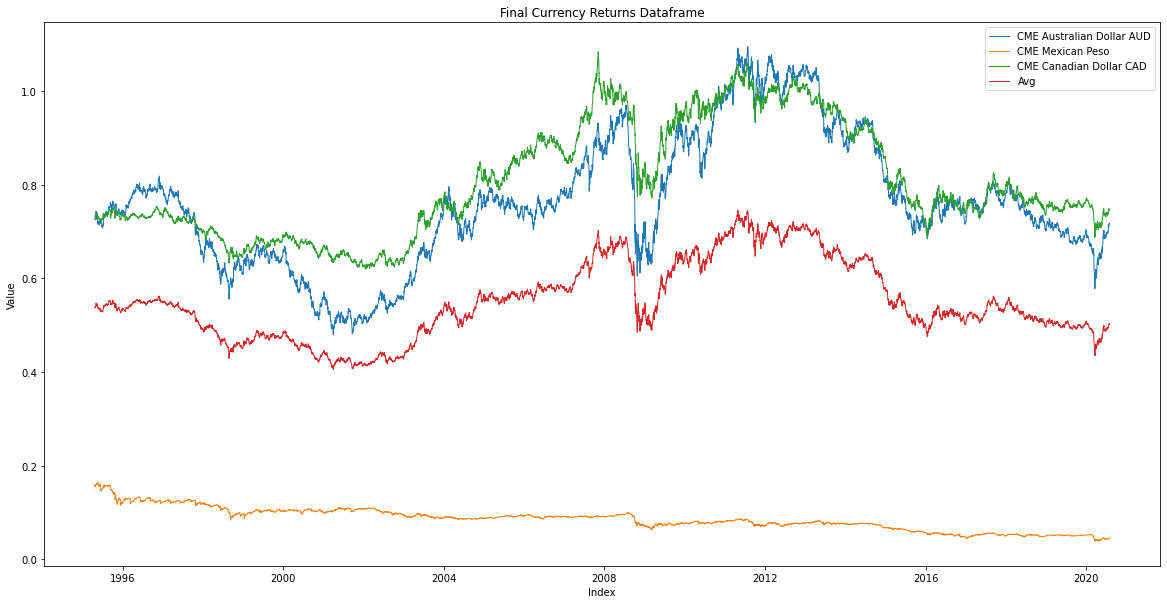

In [8]:
# Truncating currency data frame to first AUD date
mask = currency_close_df['CME Mexican Peso'].isnull()

currency_close_df = currency_close_df.loc[np.logical_not(mask)]
series_plot(currency_close_df, 'Final Currency Returns Dataframe', legend=True)

This leaves us with a final dataframe filled with returns data for each of our three currencies and their simple average. Next, we check that these returns are distributed appropriately.

### Distribution of Currencies Returns

Many desirable results necessitate the assumption that returns data is approximately normally distributed. To be clear, we define the return $r_{S,t}$ of a stock $S$ on day $t$ as 
$$
r_{S,t} = \frac{p_{s,t} - p_{S,t-2}}{p_{S,t-2}}
$$
where $p_{S,t}$ denotes the close price of stock $S$ on day $t$.

We now aim to validate that claim for our data. First, we constuct a series for each of our currencies which is mean-zero (by taking two day returns) and standardised by a rolling estimate of its standard deviation. Empircally we can show that a longer rolling period overestimates the variance of the returns and a shorter window underestimates it. This may be because the window size begins to take into account data from a distribution too different from the observation on the current day, a theme we will revisit often during this project. This also suggests that the data is not strictly stationary, as the observations do not have constant variance.

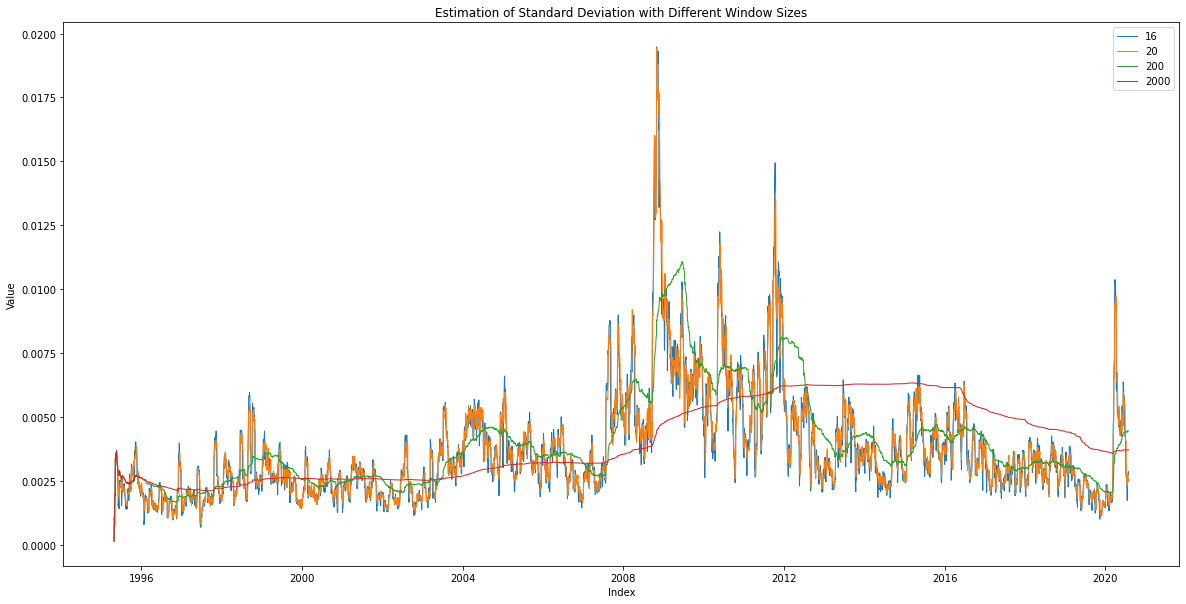

In [9]:
# Check series of standard deviation estimates for different rolling windows
std_plot = pd.DataFrame([], index=currency_close_df.index)
for window_size in [16,20,200,2000]:
    std_plot[window_size] = currency_close_df['Avg'].diff(periods=2).rolling(window_size,min_periods=1).std()
series_plot(std_plot,'Estimation of Standard Deviation with Different Window Sizes',legend=True)

We choose a rolling window of 15 days as this yields a distribution closest to a standard normal. This corresponds to 3 business weeks.

In [10]:
# Normalised return dataframe
norm_currency_returns = pd.DataFrame([]).reindex_like(currency_close_df)

# Fill datafrane
for currency in currency_close_df:
    
    currency_returns_series = currency_close_df[currency].diff(periods=2) / currency_close_df[currency].shift(2)
    
    currency_std_series = currency_returns_series.rolling(15, min_periods = 10).std()
    
    norm_currency_returns[currency] = currency_returns_series / currency_std_series

Text(0.5, 1.0, 'QQ Plots of 2-day Standardised Returns Against Theoretical Std Normal Quantities')

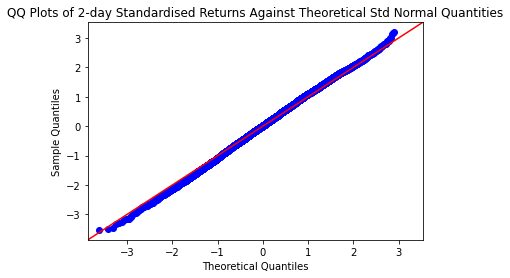

In [11]:
from statsmodels.graphics.gofplots import qqplot
qqplot(norm_currency_returns['Avg'], line="45")
plt.title('QQ Plots of 2-day Standardised Returns Against Theoretical Std Normal Quantities')

With the choice of rolling estimate window size as outlined above, the QQ plots of the sample distribution indicate that the returns are approximately standard normally distributed, with no clear outliers. We see slightly fatter tails than expected for a normal distribution, but this is a commonly observed phenomenon with price returns series. The assumption of normality is further supported by the below Kernal Density Estimation of the currencies' average sample distribution.

NameError: name 'sns' is not defined

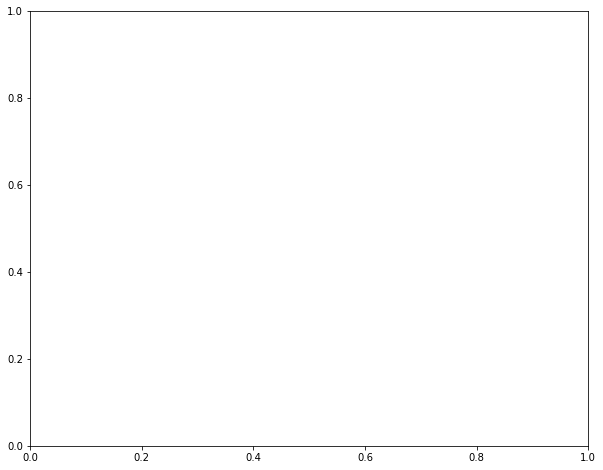

In [12]:
fig, axs = plt.subplots(1,1, figsize=(10,8))


x = np.linspace(-6, 6, 100)

sns.kdeplot(norm_currency_returns['Avg'],label='Average of Currency Returns')
axs.plot(x, stats.norm.pdf(x, 0, 1), label='Standard Normal')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('KDE of 2-day Standardised Returns Against Theoretical Std Normal Quantities')

### AutoCorrelation Plots


Now we check the autocorrelation function of the currencies' simple average. As it is the mean of three series with zero ACF, we expect this too to be zero.

In [ ]:
pd.plotting.autocorrelation_plot(norm_currency_returns['Avg'])
plt.title('Autocorrelation Lag of Normlaised Currency Returns')

The simple average of the currencies has near zero autocorrelation at all lags. This validates our choice to not include auto-correlation structure to the currency composite.

## Commodities

We have access to the historical price data of the futures contracts of around 30 globally traded commodities. Whilst each series ends in July 2020, not all commodities have complete series, and not all commodities' series begin at the same date. Here we plot each series to gain a better understanding on the shape of our data.

In [13]:
# Create list of currency names
commodity_list = pd.read_csv('Data/Commodities_List_Updated.csv')['NAME']

# Initialise empty dataframes with full indexing
commodity_dict = {commodity:  pd.DataFrame([], index = pd.bdate_range(start = '1/1/1980', end = '7/31/2020')) for commodity in commodity_list}

# Loop through each currency and load the data into the waiting dataframne
for commodity in commodity_list:
    
    current_df = pd.read_csv('Data/Continuous Futures Series/{}.csv'.format(commodity), index_col = 0, skiprows = 0, skipfooter = 1, header = 1, engine = 'python')
    current_df.index = pd.to_datetime(current_df.index)
    
    commodity_dict[commodity] = commodity_dict[commodity].join(current_df)

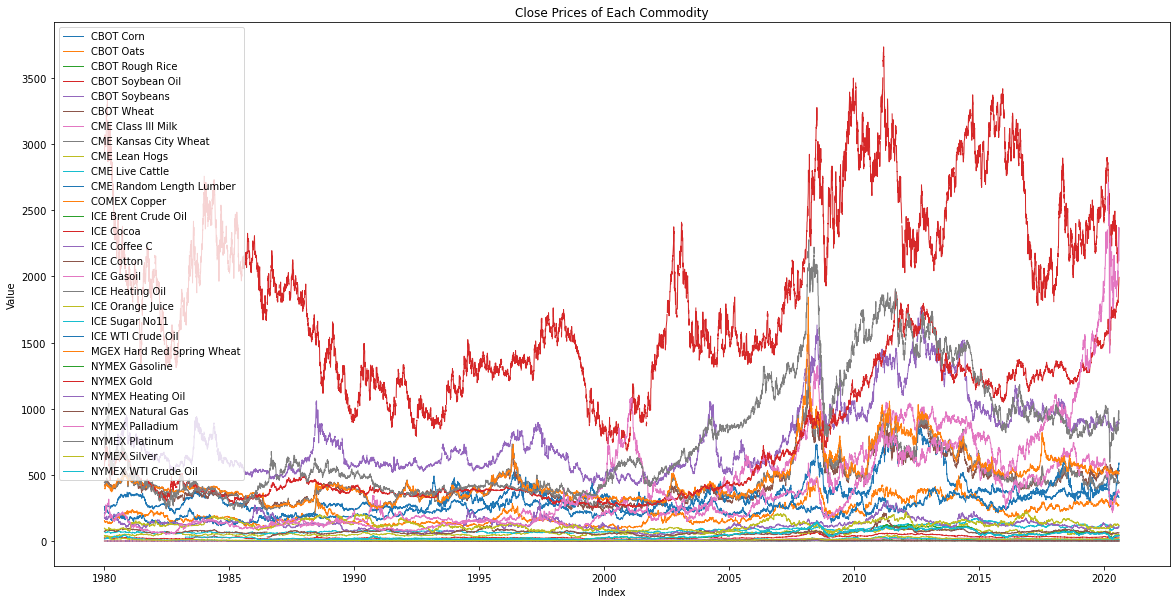

In [14]:
# Create empty dataframe of currency close prices to be filled in
commodity_close_df = pd.DataFrame([], index = commodity_dict['CBOT Corn'].index)

# Loop through each currency dataframe and pull its close price data
for commodity in commodity_list:
    
    commodity_close_df[commodity] = commodity_dict[commodity]['Close']
    
series_plot(commodity_close_df,'Close Prices of Each Commodity',legend=True)

To be consistent with our currencies data series, we trim these series to begin at the same date. As we will not use all of the commodities series in the same analyses, we do not trim them to their minimum index yet.

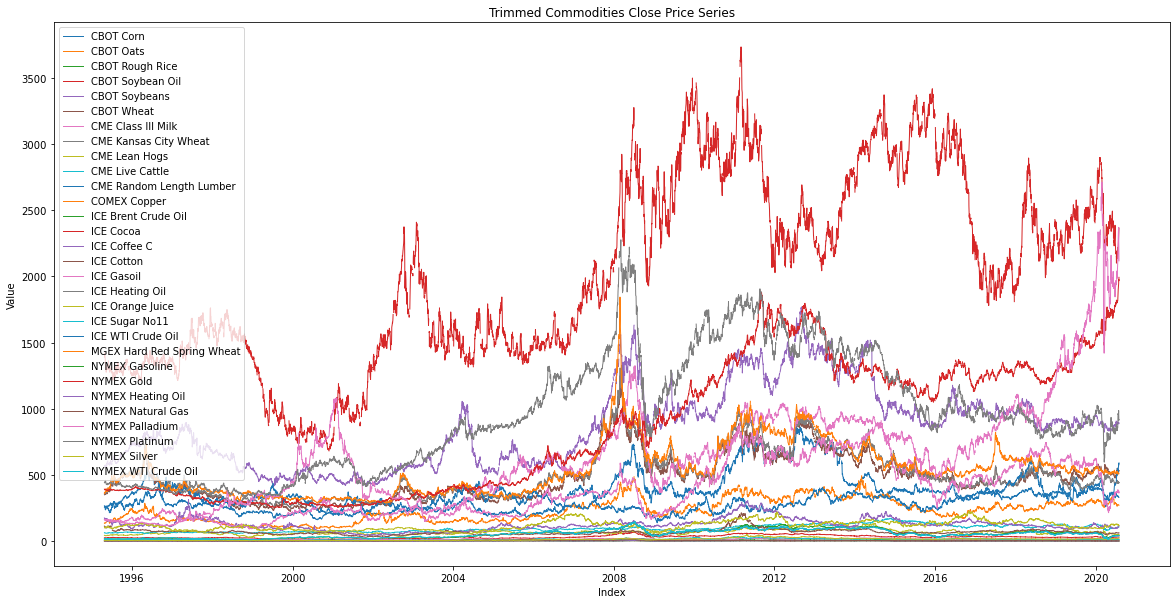

In [15]:
commodity_close_df = commodity_close_df.loc[currency_close_df['Avg'].index]
series_plot(commodity_close_df,'Trimmed Commodities Close Price Series', legend=True)

With so many commodity series plotting together, it is a little difficult to see the days where data is unavailable. In an effort to analyse these gaps we plot each commodities NaN days against a false height split.

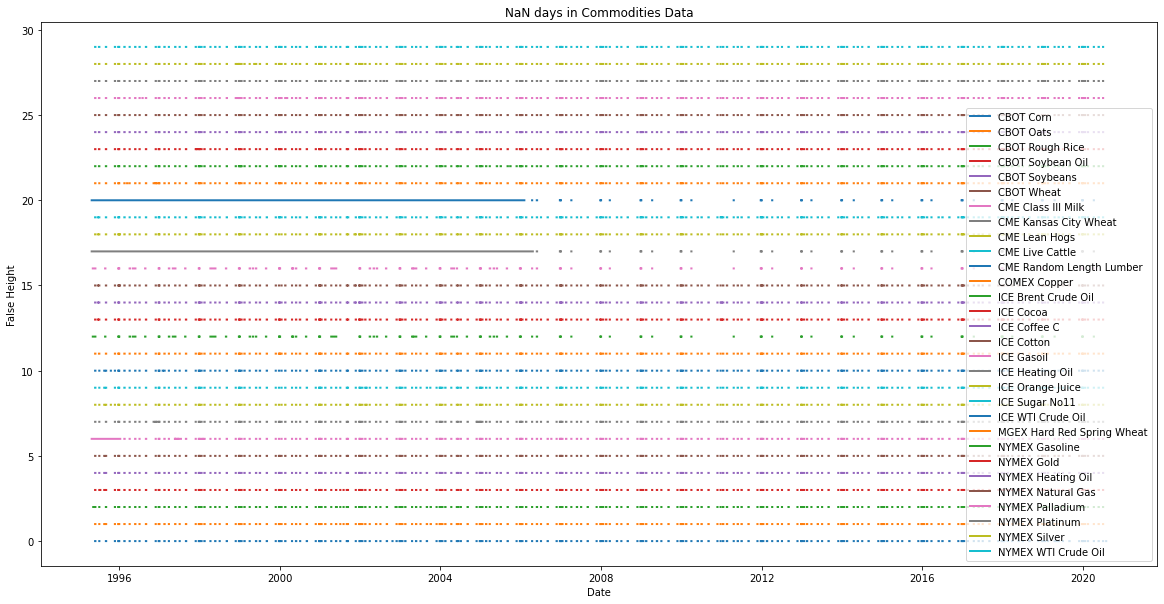

In [16]:
# Plotting NaN days to visualise missing data


na_dates = commodity_close_df.copy()

plt.figure(figsize=(20,10))
for i, contract in enumerate(na_dates.columns):

    hold_copy = na_dates[contract].copy()    
    
    na_dates[contract][pd.isnull(hold_copy) == False] = np.nan
    na_dates[contract][pd.isnull(hold_copy)] = i
    
    plt.plot(na_dates[contract],ds='steps-pre',lw=2,label = contract)

plt.title('NaN days in Commodities Data')
plt.xlabel('Date')
plt.ylabel('False Height')
plt.legend(loc=4)
plt.show()

The visualisation shows that both ICE Heating Oil and ICE Crude both have series beginning at around 2006, and Class III Milk beginning its series in 1996. Each of the other commodities has gaps only for market holidays, and each (apart from some commodities listed on the ICE) have gaps in the same places. This prompts a decision between excluding the two oils and milk or trimming every other commodity and currency to their beginning dates. As we have data for two of these three contracts listed seperately on the NYMEX, we choose to exclude these three commodities and retain 10 years of useable data.

In [17]:
# Removing shorter correlated oil series
commodity_close_df = commodity_close_df.drop(['ICE Heating Oil', 'ICE WTI Crude Oil', 'CME Class III Milk'], axis=1)

### Distribution of Commodity Returns

Here we evaluate the distribution of the returns data in the same way that we did for the currencies series. First, we constuct a series for each of our commodities which we check is mean-zero (by taking two day returns) and standardised by a rolling estimate of its standard deviation. For consistency we will use the same window size as we did for the currencies.

In [18]:
# Normalised return dataframe
norm_commodity_returns = pd.DataFrame([]).reindex_like(commodity_close_df)

# Fill datafrane
for commodity in commodity_close_df:
    
    commodity_returns_series = commodity_close_df[commodity].diff(periods=2) / commodity_close_df[commodity].shift(2)
    
    commodity_std_series = commodity_returns_series.rolling(15, min_periods = 10).std()
    
    norm_commodity_returns[commodity] = commodity_returns_series / commodity_std_series

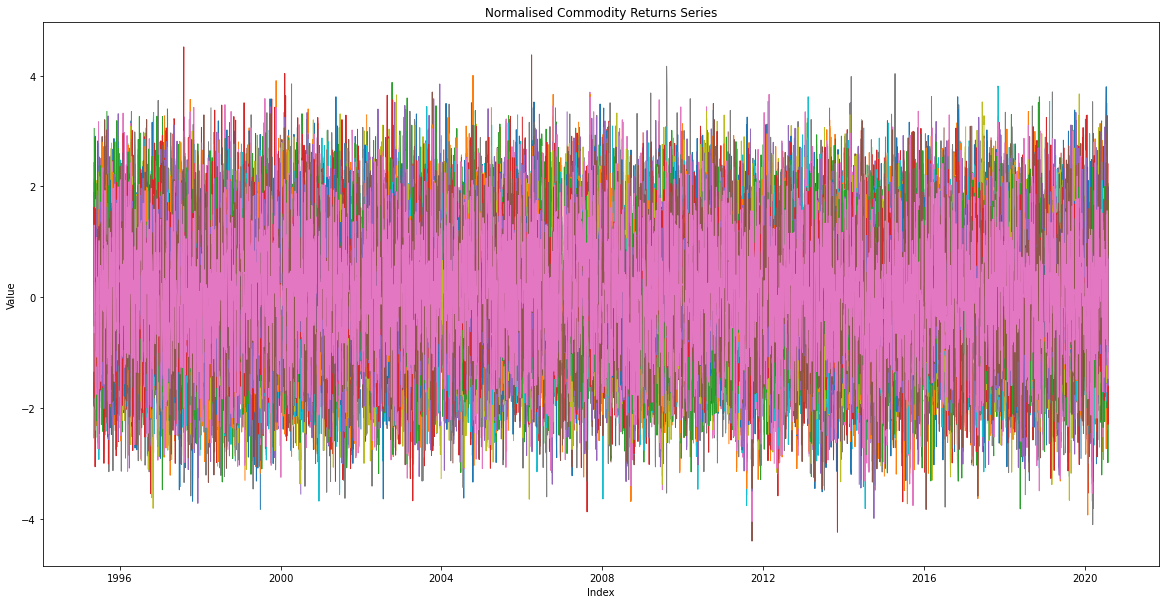

In [19]:
series_plot(norm_commodity_returns,'Normalised Commodity Returns Series')

As we are no longer interested in just a simple average, we do not have the luxury of analysing a single series. Instead, we plot the QQ-plots for the returns of each of our 30 commodities.

In [20]:
len(norm_commodity_returns.columns)

27

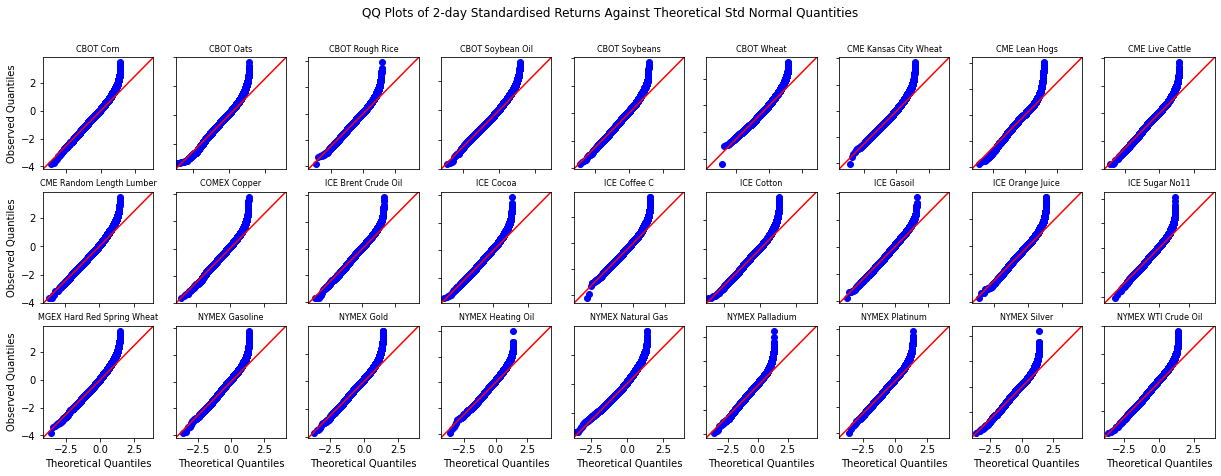

In [257]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
fig, axs = plt.subplots(3,9, figsize=(21,7))

fig.suptitle('QQ Plots of 2-day Standardised Returns Against Theoretical Std Normal Quantities')

for i, commodity in enumerate(norm_commodity_returns):
    
    qqplot(norm_commodity_returns[commodity], ax = fig.axes[i], line="45")

for i, ax in enumerate(axs.flat):
    ax.set(xlabel='Theoretical Quantiles', ylabel='Observed Quantiles')
    ax.set_title(norm_commodity_returns.columns[i],fontsize=8)
    
for ax in fig.get_axes():
    ax.label_outer()

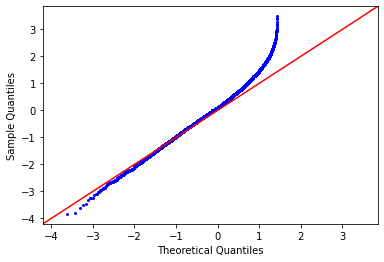

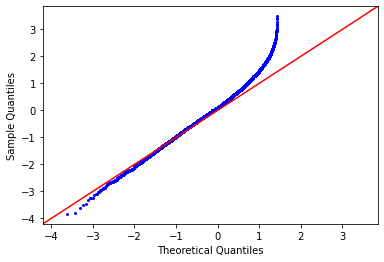

In [41]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# fig, axs = plt.subplots(3,9, figsize=(21,7))

# fig.suptitle('QQ Plots of 2-day Standardised Returns Against Theoretical Std Normal Quantities')

# for i, commodity in enumerate(norm_commodity_returns):
    
qqplot(norm_commodity_returns['CBOT Corn'], line="45", markersize=2)

# for i, ax in enumerate(axs.flat):
#     ax.set(xlabel='Theoretical Quantiles', ylabel='Observed Quantiles')
#     ax.set_title(norm_commodity_returns.columns[i],fontsize=8)
    
# for ax in fig.get_axes():
#     ax.label_outer()

C:\Users\andre\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\andre\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  2.,   0.,   1.,   2.,   0.,   1.,   3.,   3.,   3.,   6.,   3.,
          8.,  17.,   9.,  20.,  15.,  38.,  21.,  33.,  46.,  46.,  62.,
         58.,  69.,  85.,  88., 110., 118., 127., 146., 148., 151., 203.,
        196., 196., 222., 219., 240., 231., 276., 222., 217., 218., 214.,
        182., 197., 183., 156., 143., 137., 105., 109., 133.,  87.,  76.,
         76.,  64.,  59.,  57.,  44.,  32.,  28.,  32.,  22.,  18.,  21.,
          6.,  15.,   2.,   6.,   2.,   5.,   1.,   1.,   2.]),
 array([-3.83306109, -3.73545553, -3.63784996, -3.54024439, -3.44263883,
        -3.34503326, -3.2474277 , -3.14982213, -3.05221656, -2.954611  ,
        -2.85700543, -2.75939986, -2.6617943 , -2.56418873, -2.46658317,
        -2.3689776 , -2.27137203, -2.17376647, -2.0761609 , -1.97855533,
        -1.88094977, -1.7833442 , -1.68573864, -1.58813307, -1.4905275 ,
        -1.39292194, -1.29531637, -1.1977108 , -1.10010524, -1.00249967,
        -0.90489411, -0.80728854, -0.70968297, -0.6120

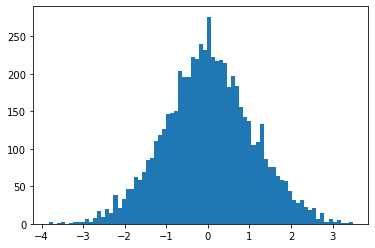

In [37]:
import scipy.stats as stats
plt.hist(norm_commodity_returns['CBOT Corn'], bins=75)

In contrast to the distribution of the currency simple average, the standartdised additive returns of the commodities appear to have much more weight in their right tails. This may be because the price of commodities increases with a near linear drift term, however this result in positive mean return. This is one factor we must take into account when considering our brownian motion generation of commodities prices, as this could be modelled well with a positive drift term.

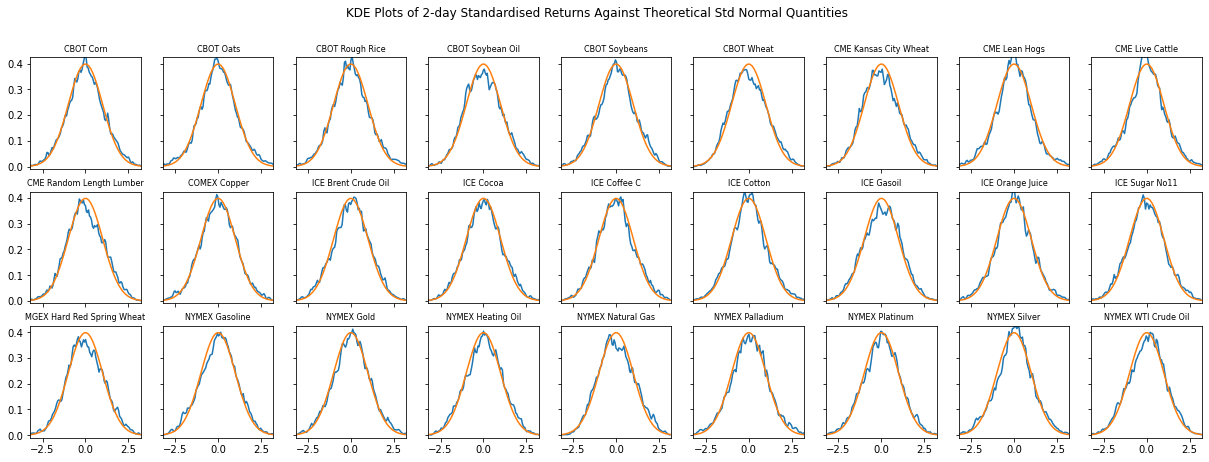

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

fig, axs = plt.subplots(3,9, figsize=(21,7))

fig.suptitle('KDE Plots of 2-day Standardised Returns Against Theoretical Std Normal Quantities')

x = np.linspace(-6, 6, 100)

for i, commodity in enumerate(norm_commodity_returns):
    sns.kdeplot(norm_commodity_returns[commodity], ax = fig.axes[i], legend=False, bw=0.05)
    fig.axes[i].plot(x, stats.norm.pdf(x, 0, 1))
    
for i, ax in enumerate(axs.flat):
#     ax.set(xlabel='Theoretical Quantities', ylabel='Observed Quantities')
    ax.set_title(norm_commodity_returns.columns[i],fontsize=8)
    ax.set_ylim(-0.01,0.425)
    ax.set_xlim(-3.22,3.22)

for ax in fig.get_axes():
    ax.label_outer()

The above plots compare an estimate of each commodities distribution (light blue) to a standard normal distribution (orange). As expected from previous analyses, each commodity's returns have mean very close to zero, and slightly heavier tails than the standard normal of which they are assumed to be observations. Additionally the right tail looks to be marginally heavier than the left.

### AutoCorrelation Plots


Now we check the autocorrelation function of the commodities series. 

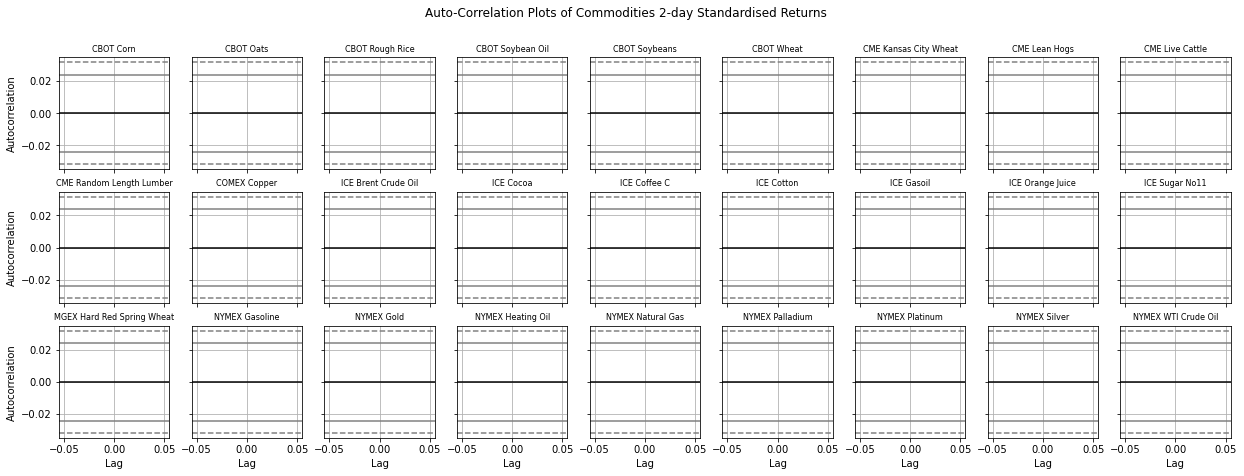

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

fig, axs = plt.subplots(3,9, figsize=(21,7))

fig.suptitle('Auto-Correlation Plots of Commodities 2-day Standardised Returns')

for i, commodity in enumerate(norm_commodity_returns):
    pd.plotting.autocorrelation_plot(norm_commodity_returns, ax = fig.axes[i])
    
for i, ax in enumerate(axs.flat):
#     ax.set(xlabel='Theoretical Quantities', ylabel='Observed Quantities')
    ax.set_title(norm_commodity_returns.columns[i], fontsize=8)

for ax in fig.get_axes():
    ax.label_outer()

The each of the currencies has near zero autocorrelation at all lags. This validates our choice to not include auto-correlation structure to the generation of the commodities series also.

### Intermarket Correlation Analysis

Later we will use the data series for commodities to backtest trading strategies. While 
tThis involves a rolling linear regression (discussed in detail later) that is not too amenable to being fed correlated data, we do not ever perform a linear regression with more than one covariate at a time. 

Our reluctance to trade correlated commodities is instead motivated by risk management. There is little difference between doubling an investment in a single market and investing an equal amount in two highly correlated markets; one would expect similar returns. Therefore we would like to limit our trading choices to "orthogonal" commodities so that we can more easily manipulate the variance of any portfolio we might make. So, here we begin to analyse the correlation of returns between commodities.

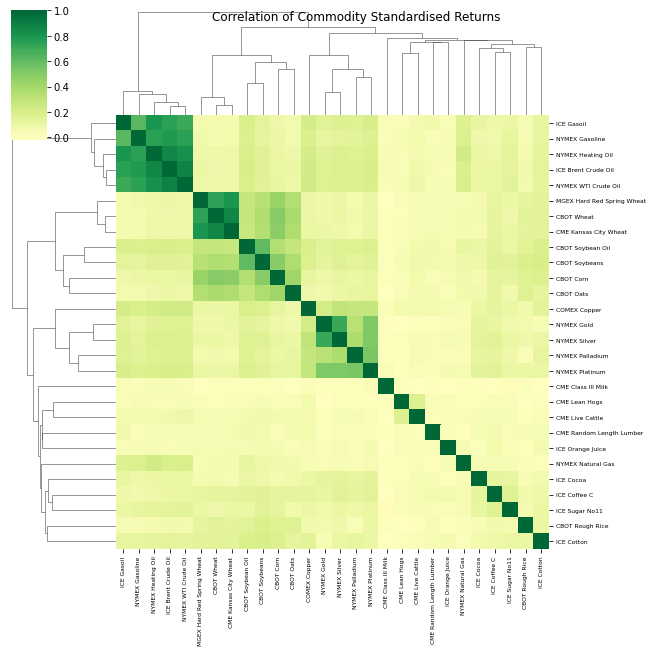

In [26]:
# Creating matrix of correlation values
commodity_correlation_mat = norm_commodity_returns.corr()

#%% Seaborn Clustermap Plot

cluster_map = sns.clustermap(commodity_correlation_mat, xticklabels = norm_commodity_returns.columns, yticklabels = norm_commodity_returns.columns, cmap="RdYlGn", center=0)

cluster_map.fig.suptitle('Correlation of Commodity Standardised Returns')

hm = cluster_map.ax_heatmap.get_position()
plt.setp(cluster_map.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)
plt.setp(cluster_map.ax_heatmap.xaxis.get_majorticklabels(), fontsize=6)
cluster_map.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height])
col = cluster_map.ax_col_dendrogram.get_position()
cluster_map.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height])

A correlation heatmap like the one above is a great way to get a broad picture of the pairwise correlations between our commodities. One can easily pick out the energies sector (the highly correlated block of 5 in the top left), as well as the futures for the three wheats. The rest of the commodities cluster into "not energies" which is made up of soft commodities such as sugar, cocoa, orange juice, and cotton. Each of these shares little correlation with another.

Another result we can spot from this plot is that no two contracts are negatively correlated. This hints at the fact that there is a force driving the returns of the commodities market. This is something that we would like to validate, as later we will want to opperate under the assumption that the returns of each commodity are positively correlated with the returns of our simple average of currencies. Our hope is that this simple average can act as the explanation of the movements in the commodities markets.

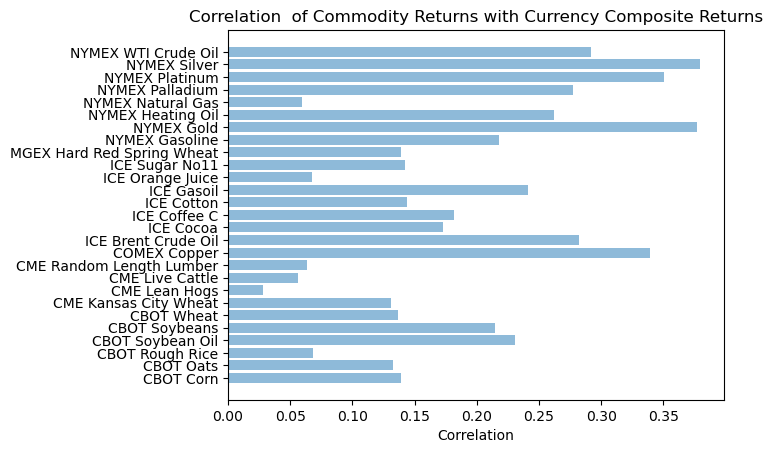

In [260]:
currency_commodity_corr = []

for commodity in norm_commodity_returns:
    currency_commodity_corr.append(norm_commodity_returns[commodity].corr(norm_currency_returns['Avg']))
    


import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

y_pos = np.arange(len(currency_commodity_corr))

plt.barh(y_pos, currency_commodity_corr, align='center', alpha=0.5)
plt.yticks(y_pos, norm_commodity_returns.columns)
plt.xlabel('Correlation')
plt.title('Correlation  of Commodity Returns with Currency Composite Returns')

plt.show()

As expected each commodity's returns are positively correlated to the returns of the currency composite's, some more than others. This at least provides evidence that there is a signal to be recovered. In the next section we will examine this signal.

## Market Simulation

Our simulation framework simulates a structured market by first generating a series of returns for the currency composite (or market benchmark), which we will call $M(t)$, with $t \in \mathbb{N}$ denoting day $t$. The series of returns for the $i^{th}$ commodity $C_i, 
\ i=1,2,\dots,d$ are therefore given by

$$
C_i = \beta_i(t) M(t) + \epsilon_i (t)
$$

where $\beta_i(t)$ is some discrete series of coefficients from some continous function $f_i(t) = \beta_i(t)$ and $\epsilon_i\sim N(0,\sigma_i)$ is some unobserved, i.i.d. noise. This looks a lot like the design matrix for a family of linear models, with the added difficulty that observations are heavily correlated (in time). Later we will analyse how best to deal with the trade off of having too many correlated observations with included too little data. It will turn out that while our estimates can be controlled, we will routinely over-estimate our confidence in our estimates.

As the question of how best to generate the currency composite $M(t)$ has been answered above, the obvious next question of how to choose an appropriate $f_i(t)$ is answered next.

### Estimating $\beta(t)$

The problem of simulating data from the model above reduces to finding an appropriate function for $f_i(t) = \beta_i(t)$. We perform a rolling linear regression to estimate what coefficient series would best model the observed commodities data.

In [69]:
# dropping missing data from average
norm_currency_returns = norm_currency_returns.drop(norm_currency_returns.index[0:2])
norm_currency_returns

,CME Australian Dollar AUD,CME Mexican Peso,CME Canadian Dollar CAD,Avg
1995-04-27,1.599574,-0.922168,1.584812,0.872730
1995-04-28,1.843938,-1.879105,1.589389,0.887648
1995-05-01,0.808672,1.346260,1.823934,2.141508
1995-05-02,0.073561,1.918327,0.091770,0.910505
1995-05-03,1.505762,1.578935,-1.685416,0.680742
...,...,...,...,...
2020-07-27,0.432899,2.943484,0.320569,0.460165
2020-07-28,0.815267,1.738823,0.663669,0.801812
2020-07-29,0.351884,0.065944,-0.038677,0.197411
2020-07-30,0.208369,-0.715321,-1.010386,-0.261864


In [70]:
class Rolling_LR_OneD():
    
    # This class uses the particular result that in one dimension beta hat is 
    # the ratio of covariance of covariate and outcome variable with variance 
    # of covariate to perform a rolling linear regression on a dataframe of any size.

    # In streamlining the code for this function, detailed analytics have been
    # removed. These can still be computed using the regular rolling LR function.
    
    
    def __init__(self):
        
        ## Initialise check that regression has not been fitted yet
        
        self.fitted = False
        self.outcome = []
        
     
        
    def fit(self, outcome, predictor, lookback, intercept = False, true_betas = []):
        
        ## Regress outcome series on predictors on a rolling window that is 'lookback' long.
        ## Intercept is not fitted by default.
         
        
        # Save inputs of regression for later analytics
        self.outcome = outcome
        self.predictor = predictor
        self.lookback = lookback
        self.true_betas = true_betas

          # Initialise empty array for beta coefficients
        self.beta_df = pd.DataFrame([[np.nan]]*predictor.shape[0], 
                                    columns = ['Beta'], 
                                    index = predictor.index)
    
        # Initialise empty array for prediction
        self.pred_ts = pd.DataFrame([[np.nan]]*predictor.shape[0], 
                                    index = predictor.index, 
                                    columns = ['Prediction'])

        # Merge outcome and predictor series into a single dataframe
        full_df = predictor.copy()
        full_df['Y'] = outcome
        
        # Foward fill all na entries in full_df
        full_df = full_df.fillna(method='ffill')
        
        # Compute beta hat estimate
        cov_mats = full_df.rolling(window = lookback).cov()
        cov_mats.reset_index(inplace=True)
        cov_mats = cov_mats[cov_mats.columns[-2:]]
        cov_mats = cov_mats[cov_mats.index % 2 == 0]
        cov_mats.reset_index(inplace=True)
        
        beta_series = cov_mats['Y'] / cov_mats[predictor.columns[0]]
        
        self.beta_df['Beta'] = np.array(beta_series)

        # Fill in prediction series
        self.pred_ts['Prediction'] = self.beta_df['Beta'] * self.predictor[self.predictor.columns[0]]


        self.fitted = True
        
        
    def coefficients(self):
        
        ## Return series of beta coefficients
        
        if self.fitted == True:
            return self.beta_df
        else:
            print('No regression fitted')
            
    def pred_series(self):
        
        ## Return prediction time series
        
        if self.fitted == True:
            return self.pred_ts
        else:
            print('No regression fitted')
    
    def beta_plot(self):
        
        ## Plot time series of beta coefficients
        
        if self.fitted == True:
            # Plot beta time series
            plt.figure(figsize=(20,10))
            for col in self.beta_df.columns:    
                plt.plot(self.beta_df[col].iloc[self.lookback:], lw=1, label = col)
            plt.xlabel('Index')
            plt.ylabel('Value of Coefficicent in Linear Regression')
            plt.title('Estimated Beta Coefficients in Rolling Linear Regression')
            plt.legend(loc=3)
            plt.show()
        else:
            print('Please fit a regression first!')    
         
    def pred_plot(self):
        
        ## Plot the fit of prediction time series
        
        if self.fitted == True:
            
            # Plot fitted time series against observed time series
            plt.figure(figsize=(20,10))
            plt.scatter(self.pred_ts[self.lookback:], self.outcome[self.lookback:], lw=1, label = 'Prediction')
            # plt.plot(outcome[lookback:], lw=1, label = 'True Outcome')
            plt.xlabel('Predicted Value')
            plt.ylabel('Observed Value')
            plt.title('Plot of Prediction Compared to True Outcome')
            plt.legend(loc=3)
            plt.show()
        
        else:
            print('Please fit a regression first!')

    def residual_plot(self):
        
        ## Plot time series of residuals
        
        if self.fitted == True:
            
            # Plot residual plot
            plt.figure(figsize=(20,10))
            # plt.scatter(x = outcome[lookback:], y = outcome[lookback:] - pred_ts[lookback:], lw=1, label = 'Prediction')
            plt.scatter(x = self.outcome[self.lookback:], y = self.pred_ts[self.lookback:], lw=1, label = 'Prediction')
            plt.ylabel('Residual Value')
            plt.xlabel('Observed Value')
            plt.title('Plot of Residuals Against True Outcome')
            plt.legend(loc=3)
            plt.show()
            
        else:
            print('Please fit a regression first!')


In [71]:
# Create empty dataframe for estimated beta series
commod_est_beta = pd.DataFrame([]).reindex_like(norm_commodity_returns)

# Loop through each commodity
for commod in norm_commodity_returns.columns:

    # Perform the rolling regression
    roll_reg = Rolling_LR_OneD()
    test = roll_reg.fit(norm_commodity_returns[commod], pd.DataFrame(norm_currency_returns['Avg']), 750)
    
    # Save the estimated coefficients
    commod_est_beta[commod] = roll_reg.beta_df


In [72]:
commod_est_beta

,CBOT Corn,CBOT Oats,CBOT Rough Rice,CBOT Soybean Oil,CBOT Soybeans,CBOT Wheat,CME Kansas City Wheat,CME Lean Hogs,CME Live Cattle,CME Random Length Lumber,...,ICE Sugar No11,MGEX Hard Red Spring Wheat,NYMEX Gasoline,NYMEX Gold,NYMEX Heating Oil,NYMEX Natural Gas,NYMEX Palladium,NYMEX Platinum,NYMEX Silver,NYMEX WTI Crude Oil
1995-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,0.088393,0.081843,-0.001629,0.180524,0.260442,0.120610,0.109579,0.040343,0.076226,0.059697,...,0.106837,0.186570,0.219848,0.330238,0.194578,0.041270,0.236780,0.414243,0.393539,0.243357
2020-07-28,0.087314,0.081376,-0.002987,0.180130,0.258851,0.119092,0.107935,0.039947,0.075733,0.059925,...,0.109558,0.185096,0.218879,0.330240,0.193695,0.042071,0.237218,0.413462,0.393574,0.242999
2020-07-29,0.086504,0.081802,-0.001711,0.180088,0.258546,0.120506,0.109298,0.038050,0.078079,0.060119,...,0.110753,0.185468,0.218083,0.330046,0.194216,0.044175,0.237113,0.412523,0.393609,0.243712
2020-07-30,0.086672,0.082335,-0.002196,0.179859,0.259067,0.120403,0.109216,0.038518,0.078247,0.060142,...,0.110886,0.184920,0.218205,0.329898,0.194758,0.044598,0.237034,0.412687,0.393578,0.244534


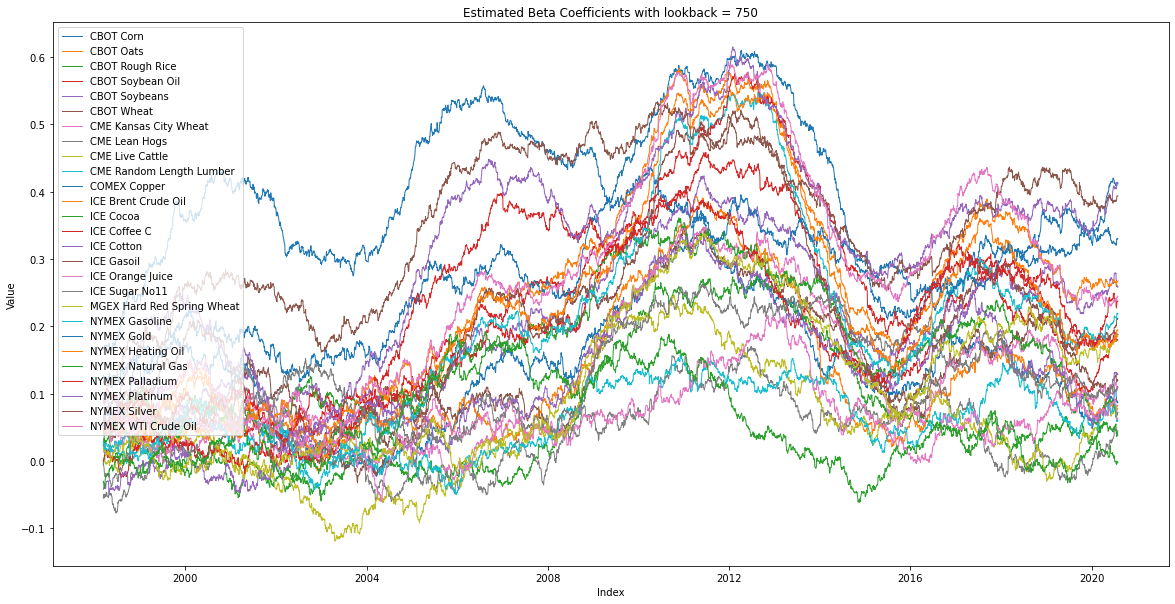

In [73]:
commod_est_beta.to_pickle('Estimated Beta Coeffs')

series_plot(pd.read_pickle('Estimated Beta Coeffs'),'Estimated Beta Coefficients with lookback = 750',legend=True)

A rolling linear regression to estimate the coefficients for each of the 27 commodities yields the series plotted above. Simple inspection suggests that the movement of each series is highly correlated. Additionally, the shape of each series inpsires a brownian motion approach to simulating the coefficients.

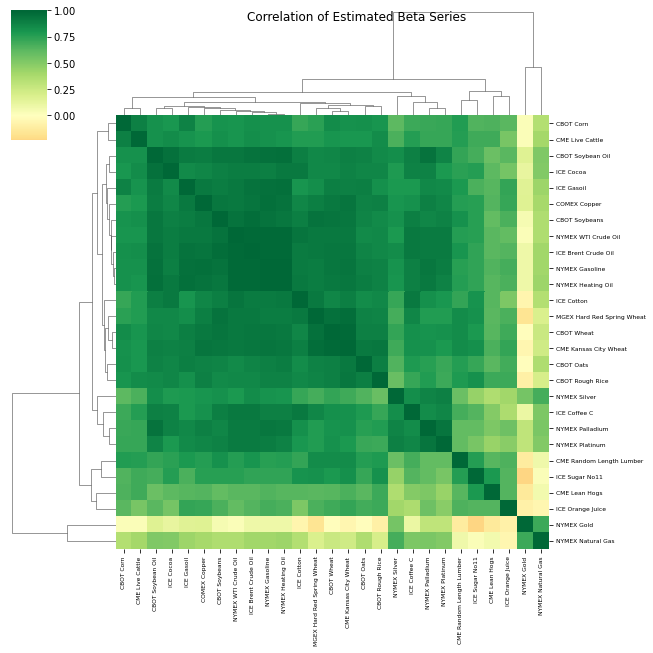

In [74]:
# Creating matrix of correlation values
beta_correlation_mat = commod_est_beta.corr()

#%% Seaborn Clustermap Plot

cluster_map = sns.clustermap(beta_correlation_mat, xticklabels = commod_est_beta.columns, yticklabels = commod_est_beta.columns, cmap="RdYlGn", center=0)

cluster_map.fig.suptitle('Correlation of Estimated Beta Series')

hm = cluster_map.ax_heatmap.get_position()
plt.setp(cluster_map.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)
plt.setp(cluster_map.ax_heatmap.xaxis.get_majorticklabels(), fontsize=6)
cluster_map.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height])
col = cluster_map.ax_col_dendrogram.get_position()
cluster_map.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height])

With the exception of the series corresponding to Gold and Natural Gas, the estimated series of beta coefficients are all highly correlated with eachother.

In [ ]:
# beta_obs_df = pd.DataFrame([], columns = norm_commodity_returns.columns).reindex_like(norm_commodity_returns)

# # series_plot(beta_obs_df, 'Observed Noisy Beta Series on Real Commodities Data', legend=True)

# import matplotlib.pyplot as plt
# import seaborn as sns
# from statsmodels.graphics.gofplots import qqplot
# import scipy.stats as stats

# fig, axs = plt.subplots(len(norm_currency_returns),2,figsize=(10,54))

# fig.suptitle('QQ Plots of 2-day Standardised Returns Against Theoretical Std Normal Quantities')


# for i, commodity in enumerate(beta_obs_df):
#     beta_plot = norm_currency_returns['Avg'] / norm_commodity_returns[commodity]
#     ax = plt.subplot(len(norm_currency_returns),2,i+1)
#     plt.plot(norm_currency_returns['Avg'] / norm_commodity_returns[commodity])
    
# for i, ax in enumerate(axs.flat):
#     ax.set_title(commodity_list[i])

# for ax in fig.get_axes():
#     ax.label_outer()
    

# ax1 = plt.subplot(311)
# plt.plot(t, s1)
# plt.setp(ax1.get_xticklabels(), fontsize=6)

# # share x only
# ax2 = plt.subplot(312, sharex=ax1)
# plt.plot(t, s2)
# # make these tick labels invisible
# plt.setp(ax2.get_xticklabels(), visible=False)

# # share x and y
# ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
# plt.plot(t, s3)
# plt.xlim(0.01, 5.0)
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# import pywt
# import pywt.data


# # Load image
# original = pywt.data.camera()

# # Wavelet transform of image, and plot approximation and details

# (cA, cD) = pywt.dwt(beta_obs_df['CBOT Corn'], 'db1')
# print(len(beta_obs_df['CBOT Corn']), len(cA))
      
# # beta_obs_df['CBOT Corn Denoised'] = cA
# # LL, (LH, HL, HH) = coeffs
# # fig = plt.figure(figsize=(12, 3))

# # for i, a in enumerate([LL, LH, HL, HH]):
# #     ax = fig.add_subplot(1, 4, i + 1)
# #     ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)


# # fig.tight_layout()
# # plt.show()

In [ ]:
# plt.scatter(beta_obs_df.index, beta_obs_df['CBOT Corn'], s=0.5)

In [25]:
norm_currency_returns['CME Australian Dollar AUD'] / norm_currency_returns['CME Canadian Dollar CAD']

1995-04-25         NaN
1995-04-26         NaN
1995-04-27    1.009315
1995-04-28    1.160155
1995-05-01    0.443367
                ...   
2020-07-27    1.350410
2020-07-28    1.228424
2020-07-29   -9.098094
2020-07-30   -0.206227
2020-07-31   -0.018540
Freq: B, Length: 6594, dtype: float64